In [1]:
% matplotlib inline

from __future__ import division

import numpy as np 
import pandas as pd 

import tweepy
from nltk.tokenize import TweetTokenizer

import re
from collections import Counter
from nltk.tokenize import TweetTokenizer

import json
import os

## Path Initialization for Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! ls
%cd '/content/drive/My Drive/Colab Notebooks/Summer 2020/Project-X/'
! ls

drive  sample_data
/content/drive/My Drive/Colab Notebooks/Summer 2020/Project-X
 Data_Utilities.py			  README.md
'Other notebooks'			  Research
'Politician Embedding Extraction.ipynb'   Tweets
 __pycache__				  twitter_credentials.json


## Adding Github Functionality to Collab

In [ ]:
# ! git config --global user.email "tg1482@stern.nyu.edu"
# ! git config --global user.name "tg1482"
# ! git status
# ! git add .
# ! git commit -m "Adding gitignore"
# ! git push

## Functions to Call new/old tweets

In [4]:
def tweets_call(twitter_handle):

    with open('twitter_credentials.json') as cred_data:
            info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    
    try:
      tweets = get_tweets(twitter_handle)
      most_recent_tweet = tweets.iloc[0][0] + 1
      tweets_bunch = 'init'
      new_tweets = []

      while len(tweets_bunch) > 0:
        tweets_bunch = api.user_timeline(screen_name = twitter_handle, count = 200, since_id = most_recent_tweet, tweet_mode = "extended")
        new_tweets.extend(tweets_bunch)
        new_num = len(new_tweets)
        print ('...{a} tweets have been downloaded for {b}'.format(a = new_num, b = twitter_handle))
        try: 
          most_recent_tweet = new_tweets[0].id + 1
        except IndexError:
          return
        
      outtweets = [[tweet.id, tweet.created_at, tweet.full_text] for tweet in new_tweets]
      df = pd.concat([pd.DataFrame(outtweets, columns=['id', 'created_at', 'text']), tweets], ignore_index=True)

    except FileNotFoundError:
      new_tweets = api.user_timeline(screen_name = twitter_handle, count = 200, tweet_mode = "extended")
      new_num = len(new_tweets)
      print ('...{a} tweets have been downloaded for {b}'.format(a = new_num, b = twitter_handle))
      outtweets = [[tweet.id_str, tweet.created_at, tweet.full_text] for tweet in new_tweets]
      df = pd.DataFrame(outtweets, columns=['id', 'created_at', 'text'])

    df.to_csv('Tweets/' + twitter_handle + '_tweets.csv', index=False, encoding = 'utf8')
            
def get_tweets(twitter_handle):
    tweet_data = pd.read_csv('Tweets/' + twitter_handle + '_tweets.csv', encoding = 'utf-8')
    tweet_data = tweet_data.dropna()
    return tweet_data

def get_old_tweets(twitter_handle, n=200):

    with open('twitter_credentials.json') as cred_data:
            info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    
    try:
      tweets = get_tweets(twitter_handle)
      first_tweet = tweets.iloc[-1][0] - 1
      new_tweets = []
      num = 0

      while num <= n:
        tweets_bunch = api.user_timeline(screen_name = twitter_handle, count = n - num, max_id = first_tweet, tweet_mode = "extended")
        new_tweets.extend(tweets_bunch)
        new_num = len(new_tweets)
        print ('...{a} tweets have been downloaded for {b}'.format(a = new_num, b = twitter_handle))
        try: 
          first_tweet = new_tweets[-1].id + 1
        except IndexError:
          return
        num += new_num
        
      outtweets = [[tweet.id, tweet.created_at, tweet.full_text] for tweet in new_tweets]
      df = pd.concat([tweets, pd.DataFrame(outtweets, columns=['id', 'created_at', 'text'])], ignore_index=True)
      df.to_csv('Tweets/' + twitter_handle + '_tweets.csv', index=False, encoding = 'utf8')

    except FileNotFoundError:
        tweets_call(twitter_handle)


# tweets = get_tweets('SenBooker')

In [5]:
reps = ["ChuckGrassley", "jaredpolis", "clairecmc", "GovChristie", "jahimes", "MayorMark", "GovGaryJohnson", "RepSteveIsrael", "SteveWorks4You", "JerryBrownGov", "PeterRoskam", "RepCohen", 
               "AndrewYang", "BenSasse", "BernieSanders", "BorisJohnson", "CoryBooker", "JeffFlake", "JoeBiden", "KamalaHarris", "MittRomney", "PeteButtigieg", "SenBooker", "SenKamalaHarris", 
               "SenSanders", "SenTedCruz", "SenWarren", "SenatorRomney", "TedCruz", "ewarren", "mcuban", "mike_pence", "realDonaldTrump"]

In [6]:
for rep in reps:
  tweets_call(rep)
  # get_old_tweets(rep, 200)

...11 tweets have been downloaded for ChuckGrassley
...11 tweets have been downloaded for ChuckGrassley
...10 tweets have been downloaded for jaredpolis
...10 tweets have been downloaded for jaredpolis
...21 tweets have been downloaded for clairecmc
...21 tweets have been downloaded for clairecmc
...0 tweets have been downloaded for GovChristie
...1 tweets have been downloaded for jahimes
...1 tweets have been downloaded for jahimes
...7 tweets have been downloaded for MayorMark
...7 tweets have been downloaded for MayorMark
...0 tweets have been downloaded for GovGaryJohnson
...3 tweets have been downloaded for RepSteveIsrael
...3 tweets have been downloaded for RepSteveIsrael
...0 tweets have been downloaded for SteveWorks4You
...1 tweets have been downloaded for JerryBrownGov
...1 tweets have been downloaded for JerryBrownGov
...0 tweets have been downloaded for PeterRoskam
...7 tweets have been downloaded for RepCohen
...7 tweets have been downloaded for RepCohen
...65 tweets have 

## Downloaded tweets till here. Building Language Model now.

In [7]:
from fastai.text import *

data_path = Path('Tweets')
# model_path = Path(os.getcwd())
bs = 48

In [8]:
train_df = pd.DataFrame()
for rep in reps:
  rep_df = get_tweets(rep)
  rep_df['rep'] = [rep]*len(rep_df)
  train_df = pd.concat([rep_df, train_df], ignore_index=True)

In [9]:
train_df.text[3]

'RT @TrumpStudents: ABSOLUTELY PACKED HOUSE \n\nfor @mattgaetz and @RichardGrenell’s speech today leading up to @DonaldJTrumpJr, @kimguilfoyle…'

In [10]:
train_df.text = train_df.text.apply(lambda x: re.sub(u'(https?:)\/\/\S*', u'', x))    # Removing 'https://'
train_df.text = train_df.text.apply(lambda x: re.sub(u'RT', u'', x))                  # Changing 'RT' to ''
train_df.text = train_df.text.apply(lambda x: re.sub(u'\&amp\;', u'and', x))          # Changing '&amp;' to 'and'

Need to find a way to mark a tweet as a RT or remove the RT altogether since the RT may not necessarily be a reflection of the tweeter's opinion but could also be a critique which not be correctly reflected.

In [11]:
# data_lm = (TextList.from_df(path = data_path, df = train_df, cols = 2)
#             .split_by_rand_pct(0.1)
#             .label_for_lm()           
#             .databunch(bs=bs))
# data_lm.save('data_lm.pk1')
data_lm = load_data(data_path, 'data_lm.pkl')

In [12]:
data_lm.show_batch()

idx,text
0,"be reporting these most important of facts , but they do n’t ! xxbos xxunk : xxup absolutely xxup packed xxup house \n \n for xxunk and @richardgrenell ’s speech today leading up to @donaldjtrumpjr , @kimguilfoyle … xxbos xxunk : xxmaj joe xxmaj biden wo n’t make an xxup honest campaign ad . xxmaj so i did it for him ! 🤣 🔥 \n @realdonaldtrump @joebiden xxbos"
1,"to be awarded the xxmaj presidential xxmaj medal of xxmaj freedom . xxmaj considering the recipients , history , and what … xxbos @gopchairwoman : xxmaj hillary xxmaj clinton is xxup still claiming the election was “ stolen ” from her . \n \n xxmaj it was n’t . \n \n xxmaj she had a failed message and xxunk … xxbos @gopchairwoman : xxmaj ever wonder why the"
2,"… xxbos @realdonaldtrump : xxmaj such a great honor . xxmaj final debate polls are in - and the xxup movement wins ! \n # americafirst # xxup maga # xxunk \n xxbos xxmaj we have tremendous momentum right now , and ca n’t let up for a moment . xxmaj join us tomorrow for our rally in xxmaj xxunk , xxup oh ! xxbos xxmaj joining @americanewsroom"
3,"indiana . xxbos @govpencein : xxmaj if we confront the challenges before us w / common sense and craft xxup in solutions to improve the lives of xxmaj hoosiers , we will move … xxbos @govpencein : xxmaj the issues confronting our state are complex , but i believe if we xxunk to our roots , stand firm on freedoms xxunk to us … xxbos @govpencein : i will not"
4,"kids . xxmaj right ? xxbos @kombiz xxmaj when do you think the far left started ? xxmaj sit xxmaj ins , xxmaj protests , end of the xxmaj vietnam xxmaj war , end of the draft , xxmaj kent xxmaj state , civil rights marches , school xxunk and busing and more . xxup all the tech we use today ? i 'm sorry the xxmaj sec xxmaj drugs"


## Language Model Training on Twitter Data

In [13]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.74E-02


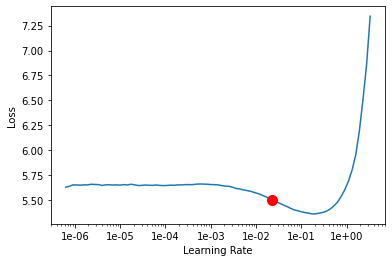

In [14]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)
min_grad_lr = learn_lm.recorder.min_grad_lr

In [15]:
learn_lm.fit_one_cycle(1, slice(1e-2,1e-1), moms=(0.8,0.7))
learn_lm.save('learn_lm_v1')

epoch,train_loss,valid_loss,accuracy,time
0,4.355686,4.084683,0.294580,01:12


In [16]:
learn_lm.freeze_to(-2)
learn_lm.fit_one_cycle(1, slice(1e-3,1e-1), moms=(0.8,0.7))
learn_lm.save('learn_lm_v2')

epoch,train_loss,valid_loss,accuracy,time
0,4.008139,3.842936,0.317019,01:14


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


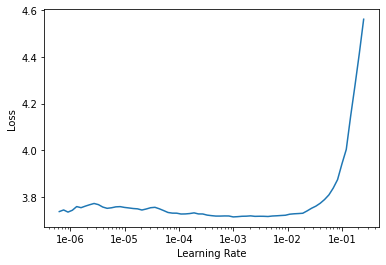

In [17]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=15)

In [18]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))
learn_lm.save('learn_lm_v3')

epoch,train_loss,valid_loss,accuracy,time
0,3.668499,3.800125,0.322212,01:27
1,3.613669,3.729041,0.330869,01:26
2,3.522271,3.691902,0.336146,01:26
3,3.436325,3.678120,0.338196,01:26
4,3.410898,3.679916,0.338418,01:26


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


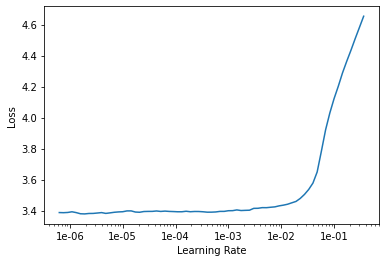

In [19]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=15)

In [22]:
TEXT = "Guns should be banned "
N_WORDS = 40
N_SENTENCES = 2

In [23]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Guns should be banned  in distribution . It ’s time to change it . It ’s up to the Senate to pass the Protect Families Act , which i introduced in my Senate desk and today 's
Guns should be banned  in California . This is a great delay and we need to pass commonsense gun safety legislation . Today the Senate must act to end these inhumane sentences and bring justice to victims of gun violence


In [24]:
learn_lm.save('learn_lm_final')
learn_lm.save_encoder('fine_tuned_enc')

## Classification of Tweets by Rep to extract Rep-Embedding

Trying to classify tweets into 

In [25]:
from collections import Counter

Counter(train_df.rep)

Counter({'AndrewYang': 3602,
         'BenSasse': 3227,
         'BernieSanders': 3456,
         'BorisJohnson': 2077,
         'ChuckGrassley': 1240,
         'CoryBooker': 3425,
         'GovChristie': 1202,
         'GovGaryJohnson': 1221,
         'JeffFlake': 2866,
         'JerryBrownGov': 1215,
         'JoeBiden': 2132,
         'KamalaHarris': 3462,
         'MayorMark': 1222,
         'MittRomney': 1928,
         'PeteButtigieg': 3462,
         'PeterRoskam': 1220,
         'RepCohen': 1217,
         'RepSteveIsrael': 1225,
         'SenBooker': 3432,
         'SenKamalaHarris': 3451,
         'SenSanders': 3464,
         'SenTedCruz': 3475,
         'SenWarren': 3449,
         'SenatorRomney': 500,
         'SteveWorks4You': 1116,
         'TedCruz': 3543,
         'clairecmc': 1285,
         'ewarren': 1264,
         'jahimes': 1221,
         'jaredpolis': 1240,
         'mcuban': 1289,
         'mike_pence': 3514,
         'realDonaldTrump': 1371})

In [26]:
reps_for_clas = ["BernieSanders", "JoeBiden", "MittRomney", "SenKamalaHarris", "SenTedCruz", "SenWarren", "SenatorRomney", "mcuban", "mike_pence", "realDonaldTrump"]
df_clas = train_df.loc[train_df.rep.apply(lambda rep: rep in reps_for_clas)]

In [27]:
df_clas

,id,created_at,text,rep
0,1280518510184144898,2020-07-07 15:06:18,,realDonaldTrump
1,1280517860725530624,2020-07-07 15:03:43,,realDonaldTrump
2,1280484878744793090,2020-07-07 12:52:40,“COVID-19 (China Virus) Death Rate PLUNGES Fro...,realDonaldTrump
3,1280384628453498880,2020-07-07 06:14:18,@TrumpStudents: ABSOLUTELY PACKED HOUSE \n\nf...,realDonaldTrump
4,1280383987068829696,2020-07-07 06:11:45,@FogCityMidge: Joe Biden won’t make an HONEST...,realDonaldTrump
...,...,...,...,...
51555,835209701457526784,2017-02-24 19:28:04,Now is the time for the American people to dem...,BernieSanders
51556,835172577345699840,2017-02-24 17:00:33,I believe you are entitled to justice and to e...,BernieSanders
51557,834818062339756032,2017-02-23 17:31:50,@MoveOn: .@SenSanders wants you to join him o...,BernieSanders
51558,834807788828233729,2017-02-23 16:51:01,One of the great and ongoing struggles of huma...,BernieSanders


In [28]:
# data_clas = (TextList.from_df(path = data_path, df = df_clas, cols = 2, vocab=data_lm.vocab)
#             .split_by_rand_pct(0.1)
#             .label_from_df(cols=3)           
#             .databunch(bs=bs))
# data_clas.save('data_clas.pkl')
data_clas = load_data(data_path, 'data_clas.pkl', bs=16)

In [29]:
data_clas.show_batch()

text,target
xxbos xxmaj george xxmaj floyd \n xxmaj ahmaud xxmaj arbery \n xxmaj breonna xxmaj taylor \n xxmaj michael xxmaj brown \n xxmaj trayvon xxmaj martin \n xxmaj eric xxmaj garner \n xxmaj philando xxmaj castile \n xxmaj sandra xxmaj bland \n xxmaj xxunk mcdonald \n xxmaj tamir xxmaj rice \n xxmaj jordan xxmaj davis \n xxmaj alton xxmaj sterling,SenKamalaHarris
"xxbos xxrep 4 . xxmaj federal xxmaj judges ( many more to come ) , two great new xxmaj supreme xxmaj court xxmaj justices , the xxmaj mexico xxmaj city xxmaj policy , and a whole new and positive attitude about the xxmaj right to xxmaj life . xxmaj the xxmaj radical xxmaj left , with late term abortion ( and worse ) , is xxunk on this issue .",realDonaldTrump
"xxbos xxrep 4 . xxmaj conditions , drug prices down for first time in 51 years ( and soon will drop much further ) , xxmaj right to xxmaj try , protecting your 2nd xxmaj amendment , big xxmaj tax and xxmaj reg xxmaj cuts , 3.2 xxup gdp , xxmaj strong xxmaj foreign xxmaj policy , and much much more that nobody else would have been able to do",realDonaldTrump
"xxbos i met xxmaj marine xxmaj sgt . xxmaj john xxmaj peck , a quadruple xxunk who has received a double arm transplant , at xxmaj walter xxmaj reed in 2017 . xxmaj today , it was my honor to welcome xxmaj john ( xxup hero ) to the xxmaj oval , with his wonderful wife xxmaj jessica . xxmaj he also wrote a book that i highly recommend ,",realDonaldTrump
xxbos xxup attn # xxup tx : xxmaj for all xxmaj hurricane # xxmaj harvey survivors the xxmaj national xxmaj flood xxmaj insurance xxmaj policy ( xxup nfip ) xxmaj proof of xxmaj loss claim deadline is just weeks away . xxmaj the deadline to file for flood damages is one year from the date of your loss . xxmaj for more information call the xxup nfip xxmaj call xxmaj,SenTedCruz


In [30]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (22109 items)
x: TextList
xxbos,xxbos,xxbos “ xxup covid-19 ( xxmaj china xxmaj virus ) xxmaj death xxmaj rate xxup xxunk xxmaj from xxmaj peak xxmaj in xxup u.s. ” a xxmaj tenfold xxmaj decrease xxmaj in xxmaj mortality . xxmaj the xxmaj washington xxmaj times @washtimes xxmaj valerie xxmaj richardson . xxmaj we have the lowest xxmaj mortality xxmaj rate in the xxmaj world . xxmaj the xxmaj fake xxmaj news should be reporting these most important of facts , but they do n’t !,xxbos xxunk : xxup absolutely xxup packed xxup house 
 
  for xxunk and @richardgrenell ’s speech today leading up to @donaldjtrumpjr , @kimguilfoyle …,xxbos “ xxmaj president xxmaj trump champions xxmaj american greatness in his xxmaj mount xxmaj rushmore speech . ” @seanhannity @foxnews
y: CategoryList
realDonaldTrump,realDonaldTrump,realDonaldTrump,realDonaldTrump,realDonaldTrump
Path: Tweets;

Valid: LabelList (2456 items)
x: TextList
xxbos xxmaj we have a c

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


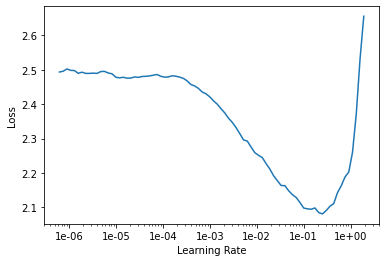

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(2, slice(1e-3,1e-1), moms=(0.8,0.7))
learn.save('first-large')

epoch,train_loss,valid_loss,accuracy,time
0,1.584988,1.347408,0.533795,00:12
1,1.338438,1.131740,0.607085,00:13


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


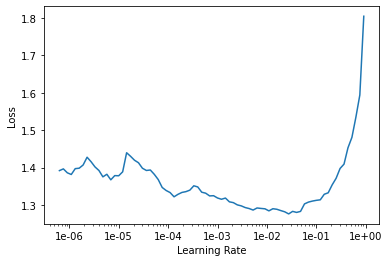

In [33]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-3/(2.6**4), moms=(0.8,0.7))
learn.save('second-large')

epoch,train_loss,valid_loss,accuracy,time
0,1.298519,1.173617,0.603827,00:15


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 5e-3/(2.6**4), moms=(0.8,0.7))
learn.save('third-large')

epoch,train_loss,valid_loss,accuracy,time
0,1.214973,1.069048,0.625407,00:25


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


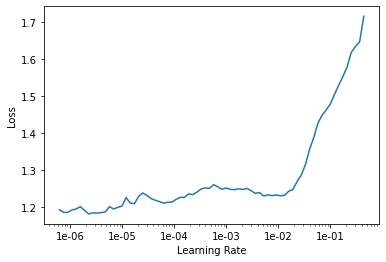

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('fourth-large')

epoch,train_loss,valid_loss,accuracy,time
0,1.103602,0.925784,0.685668,00:31
1,0.991019,0.884591,0.699511,00:32


In [38]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('fifth-large')

epoch,train_loss,valid_loss,accuracy,time
0,0.975270,0.809503,0.726384,00:32
1,0.885099,0.765219,0.742671,00:32


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


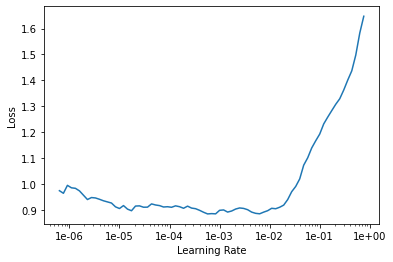

In [39]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4)), moms=(0.8,0.7))
learn.save('sixth-large')

epoch,train_loss,valid_loss,accuracy,time
0,0.861490,0.772628,0.741857,00:32


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4)), moms=(0.8,0.7))
learn.save('seventh-large')

epoch,train_loss,valid_loss,accuracy,time
0,1.055498,0.913743,0.688700,00:41
1,1.066321,0.923189,0.680201,00:42


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4)), moms=(0.8,0.7))
learn.save('eighth-large')

epoch,train_loss,valid_loss,accuracy,time
0,1.038458,0.922547,0.683349,00:38
1,1.050278,0.919923,0.684923,00:42


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


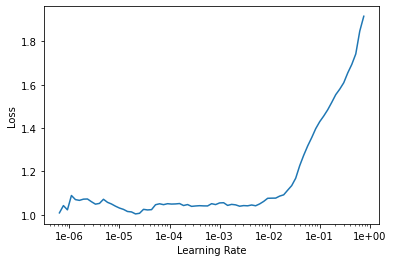

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

## Model Evaluation

In [ ]:
interp = TextClassificationInterpretation.from_learner(learn) 

In [ ]:
interp.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
xxbos,realDonaldTrump,JoeBiden,7.17,0.00
xxbos @cnnsotu : xxmaj tomorrow on # xxup cnnsotu w / @jaketapper : @senatorromney and xxunk !,BernieSanders,SenatorRomney,6.81,0.00
xxbos xxmaj it is good news that the xxmaj special xxmaj counsel has concluded that neither the xxmaj president nor his campaign xxunk with the xxmaj russian government . xxmaj it is now time for the country to move forward .,SenKamalaHarris,SenatorRomney,6.10,0.00
xxbos,realDonaldTrump,SenWarren,5.97,0.00
xxbos xxmaj this is pathetic .,SenKamalaHarris,SenTedCruz,5.96,0.00


In [ ]:
interp.show_intrinsic_attention("Immigration is the driving force behind America!")

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


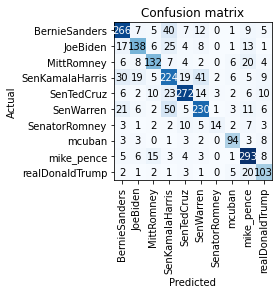

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [25, 400]            0          False     
______________________________________________________________________
RNNDropout           [25, 1152]           0          False     
______________________________________________________________________
RNNDropout           [25, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [ ]:
p = np.matrix(list(learn.model.parameters())[-2].cpu().detach().numpy())

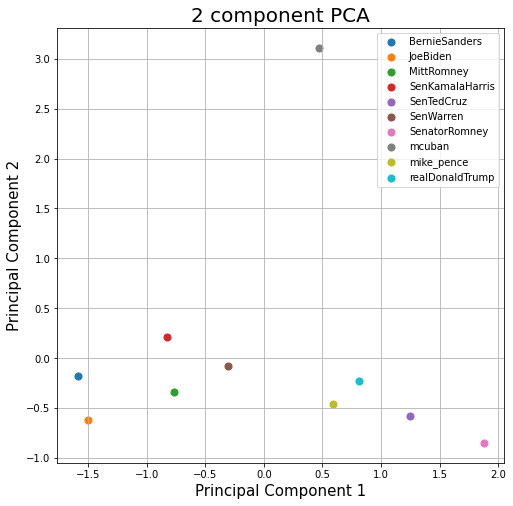

In [ ]:
targets = pd.Series(["BernieSanders", "JoeBiden", "MittRomney", "SenKamalaHarris", "SenTedCruz", "SenWarren", "SenatorRomney", "mcuban", "mike_pence", "realDonaldTrump"], name = 'targets')
finalDf = pd.concat([principalDf, targets], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target in targets:
    indicesToKeep = finalDf['targets'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
principalDf

,principal component 1,principal component 2
0,-1.589650,-0.175766
1,-1.499155,-0.617511
2,-0.766999,-0.339272
3,-0.828203,0.216285
4,1.251137,-0.576669
5,-0.310466,-0.082849
6,1.875615,-0.849427
7,0.468387,3.110376
8,0.590278,-0.458011
9,0.809056,-0.227155


In [ ]:
finalDf

,principal component 1,principal component 2,0
0,-1.589650,-0.175766,BernieSanders
1,-1.499155,-0.617511,JoeBiden
2,-0.766999,-0.339272,MittRomney
3,-0.828203,0.216285,SenKamalaHarris
4,1.251137,-0.576669,SenTedCruz
5,-0.310466,-0.082849,SenWarren
6,1.875615,-0.849427,SenatorRomney
7,0.468387,3.110376,mcuban
8,0.590278,-0.458011,mike_pence
9,0.809056,-0.227155,realDonaldTrump


In [ ]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [25, 400]            0          False     
______________________________________________________________________
RNNDropout           [25, 1152]           0          False     
______________________________________________________________________
RNNDropout           [25, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [ ]:
learn.model.parameters

<bound method Module.parameters of SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(20624, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(20624, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplac

In [ ]:
################### Further Development for Topic-based data filteration ########################

In [ ]:
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

def word_basket_in_text(word_list, text):
    status = True
    for word in word_list:
        if type(word)==list:
            list_status = False
            for list_word in word:
                list_status = list_status or word_in_text(list_word, text)
            status = status and list_status
        else: status = status and word_in_text(word, text)
    return status

In [ ]:
# Changing &amp; to 'and'
tweets.text = tweets.text.apply(lambda x: re.sub(u'\&amp\;', u'and', x))

# extracting URLS
tweets['urls'] = tweets.text.apply(lambda x: re.findall('http\S+', x))
tweets['text_clean'] = tweets.text.apply(lambda x: re.sub(u'http\S+', u'', x)) 

# extracting @... 
tweets['mentions'] = tweets.text.apply(lambda x: re.findall(u'@(\w+)', x))

# extracting hashtags
tweets['hashtags'] = tweets.text.apply(lambda x: re.findall(u'#(\w+)', x))
tweets.text_clean = tweets.text_clean.apply(lambda x: re.sub(u'#', u'', x))

# Binary for Re-Tweets
tweets['retweet'] = tweets.text.apply(lambda x: 1 if len(re.findall(u'RT', x))>0 else 0)
tweets.text_clean = tweets.text_clean.apply(lambda x: re.sub(u'RT', u'', x))

In [ ]:
Healthcare = [u'care','affordable care act', u'medicare', u'obamacare',  u'benefits', u'opioid', u'abortion', u'medicaid', u'single payer', u'medication', u'prescription', u'drugs', u'hospital', u'health', u'care']
Terrorism = [u'al', u'terror', u'sanctions', u'drone', u'oil', u'gulf', u'intelligence', u'ISIS', u'military', u'nuclear']
Economy = [u'china', u'tariff', u'mexico', u'fed', u'sec', u'interest', u'rate', u'immigration', u'debt', u'unemployment', u'growth', u'inflation', u'trade war', u'dollar', u'gdp', u'g20', u'recession', u'stock', u'market']
lgbtq = [u'gay', u'lesbian', u'pride', u'community', u'lgbt', u'same-sex', u'marriage', u'orientation', u'parade', u'stonewall', u'riot', u'civil', u'homosexual', u'queer', u'conversion']

china_tariffs = ['china', 'tariff']
safe_abortion = ['abortion', ['safe', 'legal']]
abortion_ban = ['abortion', ['ban', 'restrictions', 'extreme']]
affordable_care = ['health', ['affordable', 'obamacare', 'medicare', 'care']]
medicare = ['MedicareForAll', ['Medicare']] 
greennewdeal = ['greennewdeal']
lgbtq_marriage_equality_act = [['marriage', 'relationship', 'relationships', 'couple', 'couples'], ['gay', 'lesbian', 'pride', 'orientation']]


In [ ]:
# Final List

# Healthcare
affordable_care = ['health', ['affordable', 'obamacare', 'medicare', 'care']]
medicare = ['medicare'] 
safe_abortion = ['abortion', ['safe', 'legal']]
abortion_ban = ['abortion', ['ban', 'restrictions', 'extreme']]

# Education
education_for_all = ['education', ['afford', 'free']]
student_loans = ['student', ['cancel', 'loans', 'debt']]

# Immigration
immigration = ['immigration', ['policy', 'policies', 'mexico', 'illegal', 'undocumented', 'border']]
asylum = ['border', ['detention', 'families', 'family', 'asylum']]

# Guns
Gun_Laws = ['gun', ['semi-automatic', 'assault', 'shooting', 'reform', 'open carry', 'second amendment']]

#Climate
Global_Warming = ['climate', ['global warming', 'emissions', 'pollution', 'accord', 'fossil', 'fuel', 'oil']]
GND = [['net-zero', 'net zero', 'carbon', 'green']]
       


In [ ]:
all_tweets = ''
for tweet in tweets['text']:
    if word_basket_in_text(GND, tweet):
        print('-------')
        tweet = re.sub(u'\&amp\;', u'and', tweet)
        tweet = re.sub(u'http\S+', u'', tweet)
        tweet = re.sub(u'@(\w+)', u'', tweet)   
        tweet = re.sub(u'-', u' ', tweet) 
        print(tweet)
        all_tweets = all_tweets + ' ; ' + tweet

-------
RT : We must take bold action on climate change and create a green economy that benefits all Americans. Thank you to …
-------
RT : In NJ driving on the Turnpike with my State Director  (and his green tie) this morning—heading to a great round tabl…
-------
RT : Bob Menendez is a champion for protecting New Jersey’s beaches, coastal communities and green spaces. Today, Bob joined wi…
-------
RT : Our most vulnerable communities are disproportionately impacted by pollution + hit first and worst by climate change. Learn…
-------
                                                61. Green Latinos  opposes the Senate  health care bill
-------
                                                60. Green For All  opposes the Senate  health care bill


In [ ]:
tknzr = TweetTokenizer()
counts = Counter(tknzr.tokenize(all_tweets))
print(counts)

Counter({'the': 45, 'and': 35, '.': 34, 'our': 26, ',': 25, 'border': 25, 'to': 23, 'of': 22, ';': 21, 'immigration': 20, 'a': 15, 'I': 12, 'at': 8, 'illegal': 8, 'in': 8, 'have': 7, 'that': 7, 'wall': 7, '’': 6, 'as': 6, 'The': 6, ':': 6, 'southern': 6, 'crisis': 6, 'for': 6, 'country': 6, 'an': 5, 'want': 5, 'see': 5, 'is': 5, 'broken': 5, 'system': 5, 'secure': 5, 'people': 5, 'Texans': 4, 'agents': 4, 'human': 4, 'children': 4, 'today': 4, 'by': 4, 'humanitarian': 4, 'we': 4, 'We': 4, 'called': 4, 'building': 4, 'necessary': 4, 'step': 4, 'stopping': 4, 'flow': 4, 'into': 4, 'defending': 4, 'overwhelming': 3, 'majority': 3, 'they': 3, 'secured': 3, 'Border': 3, 'Patrol': 3, 'legal': 3, '#SecureTheBorder': 3, 'has': 3, 'security': 3, 'must': 3, 'need': 3, 'put': 3, 'catch': 3, 'release': 3, 'which': 3, 'on': 3, '>': 3, 'long': 3, 's': 3, 'who': 3, 'American': 3, 'are': 3, 'Texas': 2, 'supported': 2, 'championed': 2, 'traffickers': 2, 'drug': 2, 'produced': 2, 'RT': 2, 'A': 2, 'exist